In [499]:
"""Exploring BeautifulSoup to scrape syosetu page"""
from bs4 import BeautifulSoup
from urllib.request import urlopen
import matplotlib.pyplot as plt 
from datetime import datetime 
from typing import List, Tuple
import pandas as pd 
import string, re

url = r"https://ncode.syosetu.com/n7855ck/"
html = urlopen(url)
bs = BeautifulSoup(html, 'lxml')

print(pd.NaT)

NaT


In [500]:
def remove_punctuation(data: List[object], join=False) -> List[str]:
    """
    Remove punctuation from each string in a list of `bs4.element.Tag`s
    """
    if isinstance(data, str):
        return re.sub(r'([^\w\s]|_)','', data)
    
    print(data)
    
    for i, t in enumerate(data):
        data[i] = re.sub(r'([^\w\s]|_)','', t.string)
    
    if join: 
        return "".join(data)
    
    return data 

In [501]:
def get_novel_info(bs: BeautifulSoup) -> List[str]:
    title = bs.find(name='title').string
    
    author = bs.find(
        'div', class_='novel_writername'
    ).contents[1].string
    
    return title, author

First line(s) of summary are often some sort of advertisement. Ignore this for now.

In [502]:
def get_summary(bs: BeautifulSoup) -> str:
    summary = bs.find('div', id='novel_ex').stripped_strings
    return ''.join(list(summary))

In [503]:
def get_volume_titles(bs: BeautifulSoup) -> List[str]:
    volumes = bs.find_all('div', class_='chapter')
    
    if not volumes: return []
    
    for i, t in enumerate(volumes):
        volumes[i] = re.sub(r'([^\w\s]|_)','', t.string)
        
    return volumes

In [504]:
def get_section_titles(bs: BeautifulSoup) -> List[str]:
    chapters = bs.find_all('div', class_='chapter')
    return remove_punctuation(chapters)

In [550]:
# kanji to number mapping 
sinogram_mapping = {'〇': 0, '一': 1, '二': 2,
                    '三': 3, '四': 4, '五': 5,
                    '六': 6, '七': 7, '八': 8,
                    '九': 9, '十': 10, '百': 100,
                    '千': 1000, '万': 10000}

def remove_non_cn_num(cn: str) -> str:
    return re.sub("[^〇一二三四五六七八九十百千万]", "", cn)

def cn_to_arb_number(num: str, mapping=sinogram_mapping) -> int:
    # https://stackoverflow.com/questions/15076443/convert-numbers-in-chinese-characters-to-arabic-numbers
        
    num = remove_non_cn_num(num)
    length = len(num)
    
    if length == 0:
        return None 
    elif 0 < length < 2:
        return mapping[num]
    elif length < 3:
        ones = mapping[num[1]]
        if ones < 10: 
            return mapping[num[0]] + ones 
        else: 
            return mapping[num[0]] * ones
    
    X = mapping[num[-1]]
    for i in range(0, length-1, 2):
        X += mapping[num[i]] * mapping[num[i+1]]
    
    return X

def get_chapter_link_and_title(subtitle: object) -> Tuple[int, str, str]:
    """Extract chapter index, link, and title"""
    
    link = "https://ncode.syosetu.com/" + subtitle.a.attrs['href']
    title = subtitle.a.string
    
    title = re.split("\s", title)
    
    if len(title) < 2:
        print(f"{title} could not be parsed into (index, title)")
        return None, link, title[0]
    
    elif len(title) > 2:
        index = title[0]
        title = ''.join(title)
        
    else:
        index, title = title 
    
    try:
        index = int(index)
    except ValueError:
        index = cn_to_arb_number(index)
    
    title = remove_punctuation(title)
    return index, link, title 

# ----------------------------------- tests ---------------------------------- #

def _test_cn_to_arb_number():
    test_data = ['一百一十四', ' 四十五', '十五', '十']
    true_values = [114, 45, 15, 10]
    
    for arb, cn in zip(true_values, test_data):
        assert arb == cn_to_arb_number(cn)
    
    return True


def _test_get_chapter_link_and_title():
    
    test_data = [
        """<dd class="subtitle">
        <a href="/n7855ck/1/">第一話　運命の出会い</a>
        </dd>
        """,
        """<dd class="subtitle">
        <a href="/n7855ck/51/">第五十一話　リツハルドの孤独な十年間　前編</a>
        </dd>
        """,
        """<dd class="subtitle">
        <a href="/n5943db/3/">2 ひとりぼっちに</a>
        </dd>
        """
    ]
    
    true_output = [
        (1, 'https://ncode.syosetu.com//n7855ck/1/', '運命の出会い'), 
        (51, 'https://ncode.syosetu.com//n7855ck/51/', '第五十一話リツハルドの孤独な十年間前編'),
        (2, 'https://ncode.syosetu.com//n5943db/3/', 'ひとりぼっちに')
    ]
    
    for true_val, test_val in zip(true_output, test_data):
        test_val = BeautifulSoup(test_val).find('dd')
        print(get_chapter_link_and_title(test_val))
        assert true_val == get_chapter_link_and_title(test_val)
        
    return True


In [551]:
def strip_dt(timestamp: str) -> str:
    """Strip non-datetime characters timestamp"""
    return re.sub("[^\d/:\s]", '', timestamp).strip()

def to_dt(timestamp: str) -> datetime:
    """Parse timestamp string as datetime object"""
    return datetime.strptime(timestamp, r"%Y/%m/%d %H:%M")   

def get_chapter_times(chapter: object) -> Tuple[datetime, datetime]:
    """Get time when chapter was created and when it was last edited, if available"""
    chapter_time = chapter.dt 
    creation_time = to_dt(strip_dt( chapter_time.contents[0] ))
    
    if chapter_time.span is not None:
        edit_time = to_dt(strip_dt( chapter_time.span.attrs['title'] ))
        return creation_time, edit_time
    else:
        return creation_time, None
    
# ----------------------------------- tests ---------------------------------- #

def _test_strip_dt():
    testset = [
        "2014/12/22 22:01 改稿",
        "!@(*&!@<><><> 2014/12/22 22:01 &^%!@(*&",
        "2014/12/22 22:01"
    ]
    
    true_value = "2014/12/22 22:01"
    for test in testset:
        assert true_value == strip_dt(test)
    
    return True 

def _test_get_chapter_info():

    test_data = [
        # test with edit time 
        """<dl class="novel_sublist2">
        <dd class="subtitle">
        <a href="/n7855ck/9/">第九話　雪国生活一日目</a>
        </dd>
        <dt class="long_update">
        2014/12/21 20:30<span title="2021/07/07 22:11 改稿">（<u>改</u>）</span></dt>
        </dl>""",
        
        # test without edit time 
        """<dl class="novel_sublist2">
        <dd class="subtitle">
        <a href="/n7855ck/23/">第二十三話　近づいた距離</a>
        </dd>
        <dt class="long_update">
        2015/01/04 00:00</dt>
        </dl>
        """
    ]
    
    true_output = [
        (datetime(2014, 12, 21, 20, 30), datetime(2021, 7, 7, 22, 11)),
        (datetime(2015, 1, 4, 0, 0), None)
    ]
    
    for data, true_output in zip(test_data, true_output):
        data = BeautifulSoup(data)
        test_output = get_chapter_times(data)
        print(test_output)
        try:
            assert true_output == test_output
        except AssertionError:
            raise AssertionError(f"True output: {true_output}\nTest output: {test_output}")            

    return True 

In [552]:
def get_chapter_info(bs: BeautifulSoup) -> pd.DataFrame:
    chapter_data = dict(
        index= [], link = [], title = [], creation_time = [], edit_time = []
    )
    
    for chapter in bs.find_all('dl', class_='novel_sublist2'):
        index, link, title = get_chapter_link_and_title(chapter)
        creation_time, edit_time = get_chapter_times(chapter)
        
        chapter_data['index'].append(index)
        chapter_data['link'].append(link)
        chapter_data['title'].append(title)
        chapter_data['edit_time'].append(edit_time)
        chapter_data['creation_time'].append(creation_time)
    
    df = pd.DataFrame(chapter_data)
    return df 

In [553]:
df = get_chapter_info(bs)

['登場人物一覧'] could not be parsed into (index, title)
['華麗なる雪妖精の活躍！？'] could not be parsed into (index, title)
['夢見る姉妹と雪妖精'] could not be parsed into (index, title)
['レヴォントレット家の食卓'] could not be parsed into (index, title)
['荒ぶる鳥と冬のごちそう'] could not be parsed into (index, title)
['魚釣りと春の装いのジークリンデ'] could not be parsed into (index, title)
['美味しいキノコと夏の風景'] could not be parsed into (index, title)
['愛妻弁当と秋の大収穫'] could not be parsed into (index, title)
['九人の兄による、ジークリンデ観察日記'] could not be parsed into (index, title)
['アイナとエメリヒ、愛の逃避行！？'] could not be parsed into (index, title)
['犬と父'] could not be parsed into (index, title)
['薔薇のお酒と愉快な宴'] could not be parsed into (index, title)
['熊肉と良妻シチュー'] could not be parsed into (index, title)
['女子に呼び出されるリツハルド。'] could not be parsed into (index, title)
['エメリヒの新婚日記、キャベツとベーコンのスープを添えて'] could not be parsed into (index, title)
['ルカの楽しいピクニック'] could not be parsed into (index, title)
['熊爺と無邪気な姉妹'] could not be parsed into (index, title)
['小話まとめ'] could not be parsed 

            creation_time
index                    
11.0  2014-12-23 21:38:00
12.0  2014-12-24 22:10:00
13.0  2014-12-25 22:53:00
14.0  2014-12-26 22:15:00
15.0  2014-12-27 14:19:00
16.0  2014-12-28 15:06:00
17.0  2014-12-29 11:34:00
18.0  2014-12-30 11:57:00
19.0  2014-12-31 00:13:00
20.0  2015-01-01 00:19:00
21.0  2015-01-02 00:00:00
22.0  2015-01-03 00:00:00
23.0  2015-01-04 00:00:00
24.0  2015-01-05 00:00:00
25.0  2015-01-06 00:00:00
26.0  2015-01-07 00:00:00
27.0  2015-01-08 00:00:00
28.0  2015-01-09 00:00:00
29.0  2015-01-10 00:00:00
30.0  2015-01-11 00:00:00


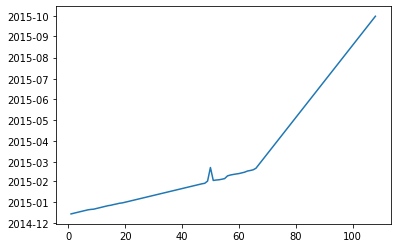

In [554]:
x = df.loc[:, ['index', 'creation_time']].dropna().set_index('index').sort_index()
print(x.iloc[10:30, :])
plt.plot(x)